## IMPORTING LIBRARIES

In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [65]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

Num GPUs Available: 1


## LOADING DATA

In [66]:
img_size = 224
batch_size = 32
csv_path = "/kaggle/input/aptos2019-blindness-detection/train.csv"
img_dir = "/kaggle/input/aptos2019-blindness-detection/train_images"
save_dir = "/kaggle/working/preprocessed_images" #to save preprocessed images

In [67]:
os.makedirs(save_dir, exist_ok=True)

In [68]:
df = pd.read_csv(csv_path)
df["id_code"] = df["id_code"].apply(lambda x: os.path.join(img_dir, x + ".png"))

## CLACHE PREPROCESSING

In [70]:
def apply_clahe_and_save(image_path, save_dir):
    # Read and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Unable to read image at path: {image_path}")
    image = cv2.resize(image, (img_size, img_size))
    
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge the LAB channels and convert back to RGB
    merged_lab = cv2.merge((cl, a, b))
    final_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)
    
    # Save the preprocessed image
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    cv2.imwrite(save_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
    
    return final_image / 255.0

In [71]:
print("Preprocessing images and saving to disk...")
for image_path in tqdm(df["id_code"], desc="Processing Images"):  # Add tqdm here
    apply_clahe_and_save(image_path, save_dir)
print("Preprocessing complete!")

Preprocessing images and saving to disk...


Processing Images: 100%|██████████| 3662/3662 [06:00<00:00, 10.15it/s]

Preprocessing complete!


## LOADING PREPROCESSED DATA INTO TF DATASET

In [72]:
def load_preprocessed_image(image_path, label):
    image = tf.io.read_file(image_path)
    
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

In [73]:
image_paths = [os.path.join(save_dir, os.path.basename(path)) for path in df["id_code"]]
labels = df["diagnosis"].values
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.shuffle(len(df)).map(load_preprocessed_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## BEFORE AND AFTER CLACHE PREPROCESS

In [74]:
def visualize_clahe_effect(df_sample):
    fig, axes = plt.subplots(len(df_sample), 2, figsize=(10, 5 * len(df_sample)))
    
    for i, row in enumerate(df_sample.itertuples()):
        img_path = row.id_code
        original = cv2.imread(img_path, cv2.IMREAD_COLOR)
        original = cv2.resize(original, (img_size, img_size))
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        processed_path = os.path.join(save_dir, os.path.basename(img_path))
        processed = cv2.imread(processed_path, cv2.IMREAD_COLOR)
        processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        
        axes[i, 0].imshow(original)
        axes[i, 0].set_title(f"Original - {row.diagnosis}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(processed)
        axes[i, 1].set_title(f"CLAHE Processed - {row.diagnosis}")
        axes[i, 1].axis("off")
    
    plt.show()

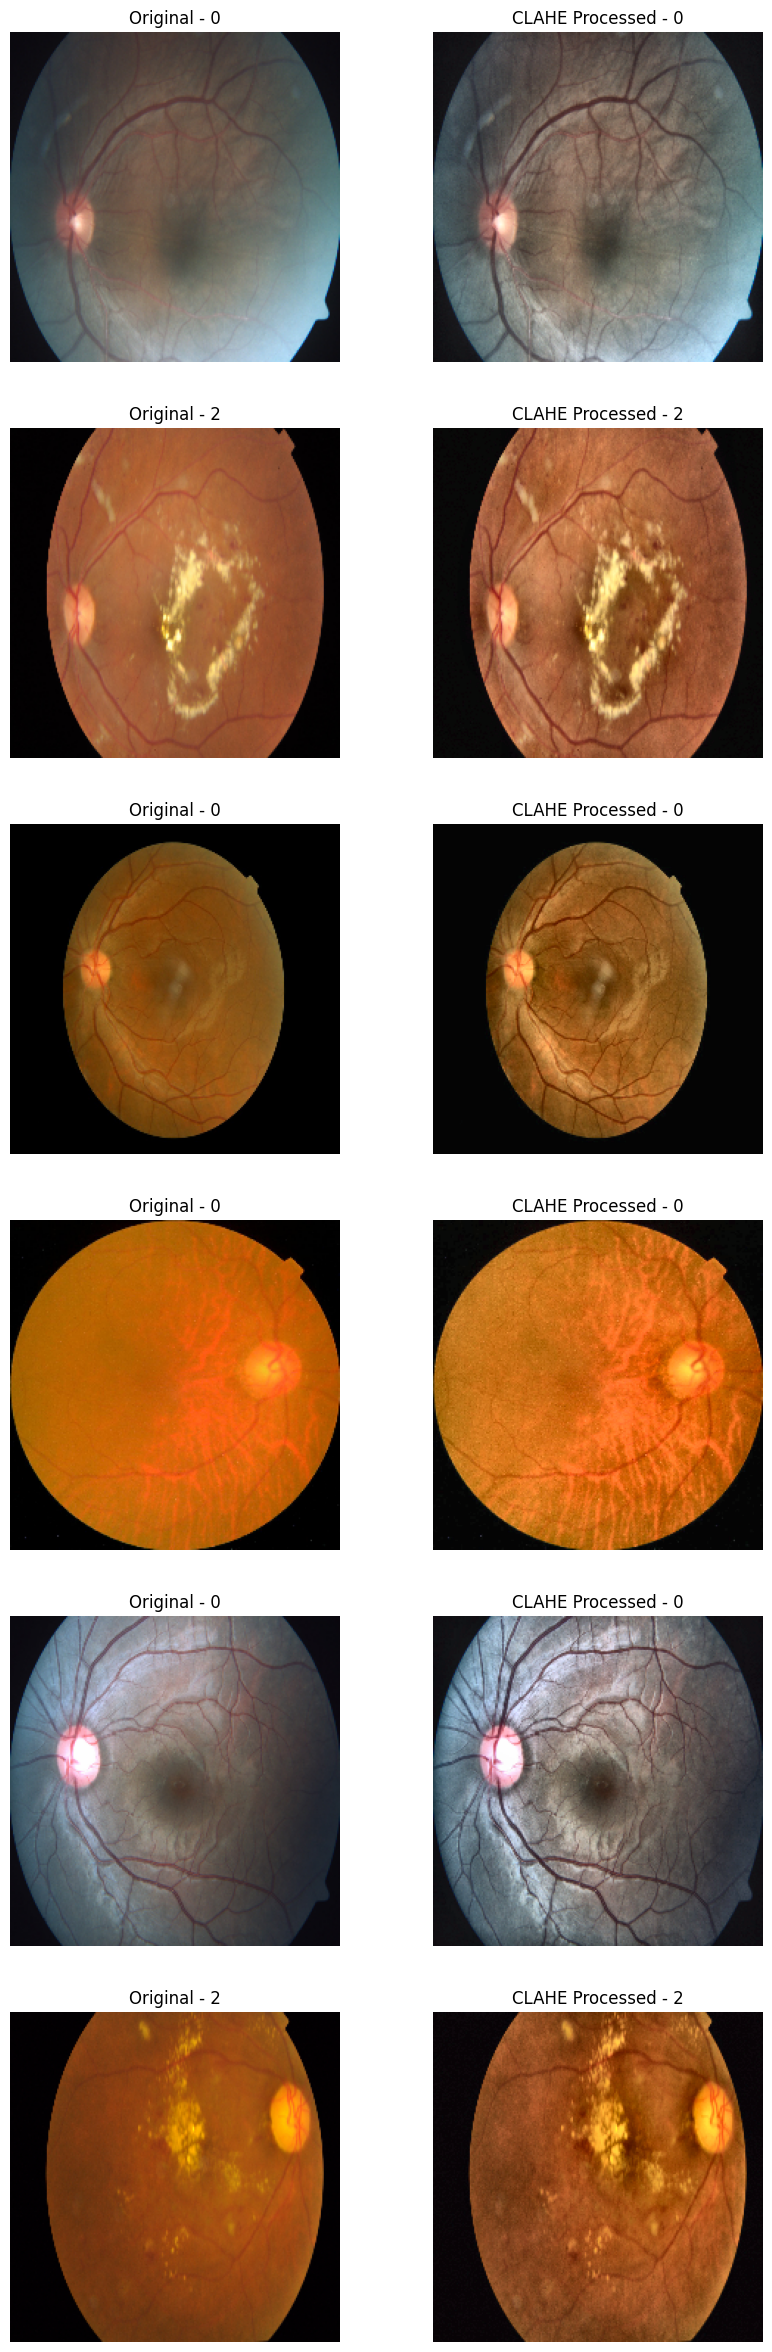

In [78]:
df_sample = df.sample(6)
visualize_clahe_effect(df_sample)

## SPLITTING AND PREFETCHING DATASET

In [79]:
def dataset_split(ds, train=0.7, val=0.15, test=0.15):
    ds_size = len(ds)
    train_size = int(ds_size * train)
    val_size = int(ds_size * val)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

In [80]:
train_ds, val_ds, test_ds = dataset_split(dataset)
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## MULTIBRANCH CNN WITH TRANSFER LEARNING

In [81]:
from tensorflow.keras.applications import DenseNet201,ResNet50
from sklearn.utils.class_weight import compute_class_weight

In [82]:
base1 = DenseNet201(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
base2 = ResNet50(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

In [83]:
base1.trainable = True
base2.trainable = True

In [84]:
for layer in base1.layers[:-10]:  # Unfreeze the last 10 layers of EfficientNetB0
    layer.trainable = False
for layer in base2.layers[:-10]:  # Unfreeze the last 10 layers of ResNet50
    layer.trainable = False

In [85]:
inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x1 = layers.GlobalAveragePooling2D()(base1(inputs))
x2 = layers.GlobalAveragePooling2D()(base2(inputs))
merged = layers.Concatenate()([x1, x2])
x = layers.Dense(256, activation="relu")(merged)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

In [86]:
multibranch_model_1 = Model(inputs, outputs)
multibranch_model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet201 (Functional)  │ (None, 7, 7, 1920)     │     18,321,984 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1920)           │              0 │ densenet201[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3968)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │      1,016,064 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 5)              │          1,285 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 42,927,045 (163.75 MB)

 Trainable params: 5,769,413 (22.01 MB)

 Non-trainable params: 37,157,632 (141.75 MB)

In [87]:
multibranch_model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [88]:
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

In [89]:
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:  # Reduce LR every 10 epochs
        return lr * 0.1
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [91]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True
)

In [94]:
multibranch_history = multibranch_model_1.fit(
    train_ds,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    class_weight=class_weights,
    validation_data=val_ds,
    callbacks=[lr_callback,early_stopping]
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.9120 - loss: 0.3276 - val_accuracy: 0.8952 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9382 - loss: 0.2693 - val_accuracy: 0.9062 - val_loss: 0.3080 - learning_rate: 1.0000e-04
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9406 - loss: 0.2372 - val_accuracy: 0.8860 - val_loss: 0.3565 - learning_rate: 1.0000e-04
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9600 - loss: 0.1949 - val_accuracy: 0.9265 - val_loss: 0.2667 - learning_rate: 1.0000e-04
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9631 - loss: 0.1508 - val_accuracy: 0.9026 - val_loss: 0.3457 - learning_rate: 1.0000e-04
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9785 - loss: 0.1105 - val_accuracy: 0.9191 - val_loss: 0.2688 - learning_rate: 1.0000e-04
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - acc

In [95]:
multibranch_model_1.save("multibranch_model_1.keras")
multibranch_model_1.save("multibranch_model_1.h5")

In [96]:
test_loss, test_acc = multibranch_model_1.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - accuracy: 0.9176 - loss: 0.2926
Test Accuracy: 92.65%


## 2D CNN

In [97]:
def build_2d_cnn(input_shape=(224, 224, 3), num_classes=5):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    # Build the model
    cnn_model = Model(inputs, outputs)
    return cnn_model

In [98]:
cnn_model = build_2d_cnn(input_shape=(img_size, img_size, 3), num_classes=5)
cnn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,784,901 (98.36 MB)

 Trainable params: 25,784,901 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [100]:
cnn_history = cnn_model.fit(
    train_ds,
    epochs=40,
    batch_size=batch_size,
    verbose=1,
    class_weight=class_weights,
    validation_data=val_ds,
    callbacks=[lr_callback]
)

Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4491 - loss: 1.5062 - val_accuracy: 0.6379 - val_loss: 0.9816 - learning_rate: 1.0000e-04
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6051 - loss: 1.2546 - val_accuracy: 0.5938 - val_loss: 0.9559 - learning_rate: 1.0000e-04
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6103 - loss: 1.2094 - val_accuracy: 0.6397 - val_loss: 0.9426 - learning_rate: 1.0000e-04
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6462 - loss: 1.1445 - val_accuracy: 0.6452 - val_loss: 0.8491 - learning_rate: 1.0000e-04
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6857 - loss: 1.0824 - val_accuracy: 0.6893 - val_loss: 0.8192 - learning_rate: 1.0000e-04
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6920 - loss: 1.0494 - val_accuracy: 0.6875 - val_loss: 0.7810 - learning_rate: 1.0000e-04
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6974 

In [101]:
cnn_model.save("cnn_model_1.keras")
cnn_model.save("cnn_model_1.h5")

In [102]:
test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7842 - loss: 0.6339
Test Accuracy: 78.32%


## VISUALIZATION OF MODEL TRAININGS

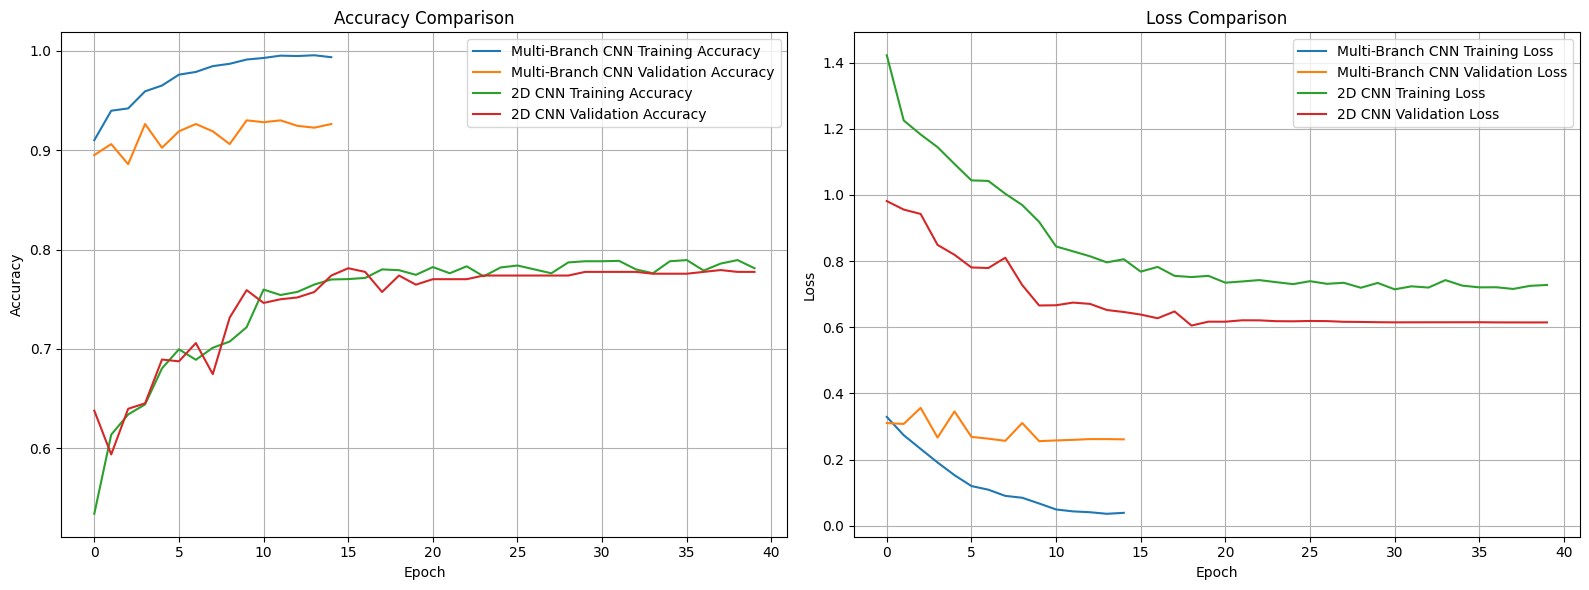

In [103]:
import matplotlib.pyplot as plt

# ✅ Convert only if still a History object
if hasattr(multibranch_history, 'history'):
    multibranch_history = multibranch_history.history

if hasattr(cnn_history, 'history'):
    cnn_history = cnn_history.history

# ✅ Plot Accuracy and Loss Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Accuracy ---
axes[0].plot(multibranch_history['accuracy'], label='Multi-Branch CNN Training Accuracy')
axes[0].plot(multibranch_history['val_accuracy'], label='Multi-Branch CNN Validation Accuracy')
axes[0].plot(cnn_history['accuracy'], label='2D CNN Training Accuracy')
axes[0].plot(cnn_history['val_accuracy'], label='2D CNN Validation Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# --- Loss ---
axes[1].plot(multibranch_history['loss'], label='Multi-Branch CNN Training Loss')
axes[1].plot(multibranch_history['val_loss'], label='Multi-Branch CNN Validation Loss')
axes[1].plot(cnn_history['loss'], label='2D CNN Training Loss')
axes[1].plot(cnn_history['val_loss'], label='2D CNN Validation Loss')
axes[1].set_title('Loss Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [104]:
multibranch_predictions = multibranch_model_1.predict(test_ds)
cnn_predictions = cnn_model.predict(test_ds)

18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [105]:
multibranch_class_labels = np.argmax(multibranch_predictions, axis=1) 
cnn_class_labels = np.argmax(cnn_predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [106]:
multibranch_cm = confusion_matrix(true_labels, multibranch_class_labels)
cnn_cm = confusion_matrix(true_labels, cnn_class_labels)

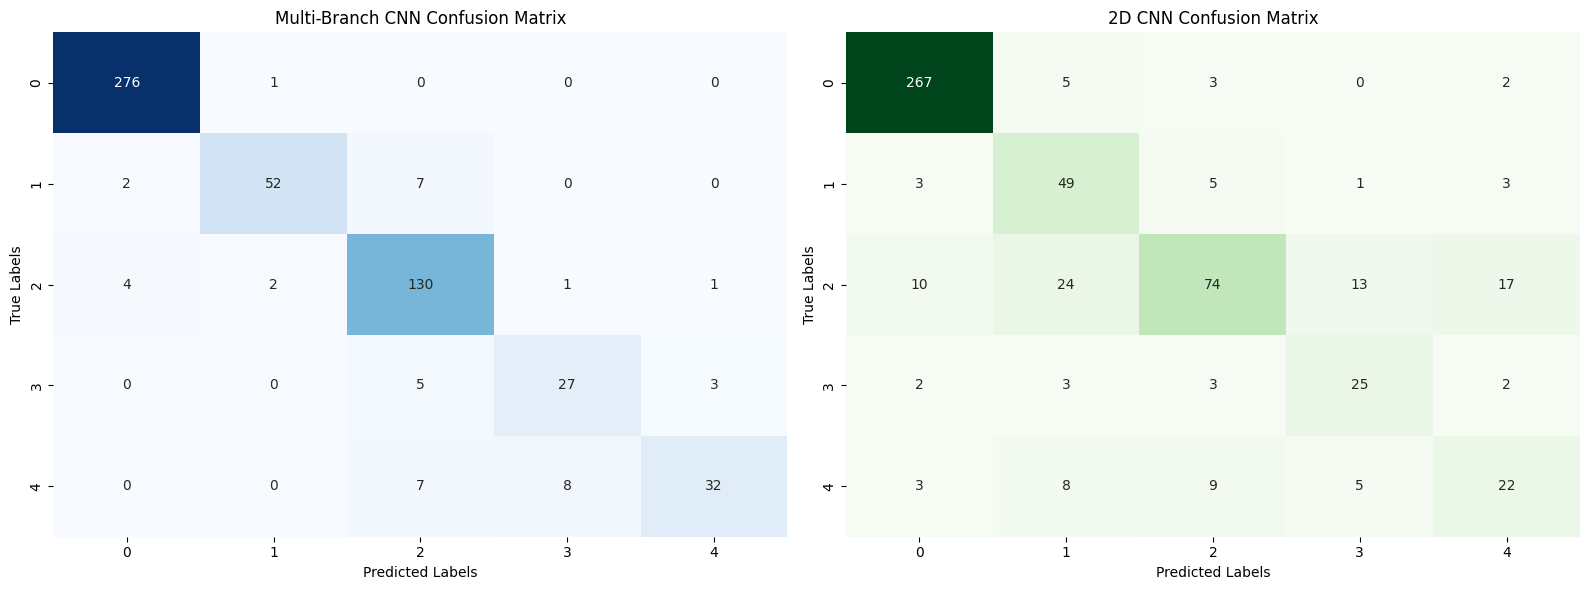

In [107]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(multibranch_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Multi-Branch CNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(1, 2, 2)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('2D CNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

## ENSEMBLE MODEL

In [108]:
multibranch_model=tf.keras.models.load_model("/kaggle/working/multibranch_model_1.h5")
cnn_model = tf.keras.models.load_model("/kaggle/working/cnn_model_1.h5")

In [109]:
weight_multibranch = 0.7
weight_cnn = 0.3

In [110]:
ensemble_predictions = (weight_multibranch * multibranch_predictions) + (weight_cnn * cnn_predictions)
ensemble_class_labels = np.argmax(ensemble_predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
ensemble_accuracy = np.mean(ensemble_class_labels == true_labels)
print(f"Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%")

Ensemble Accuracy: 93.01%


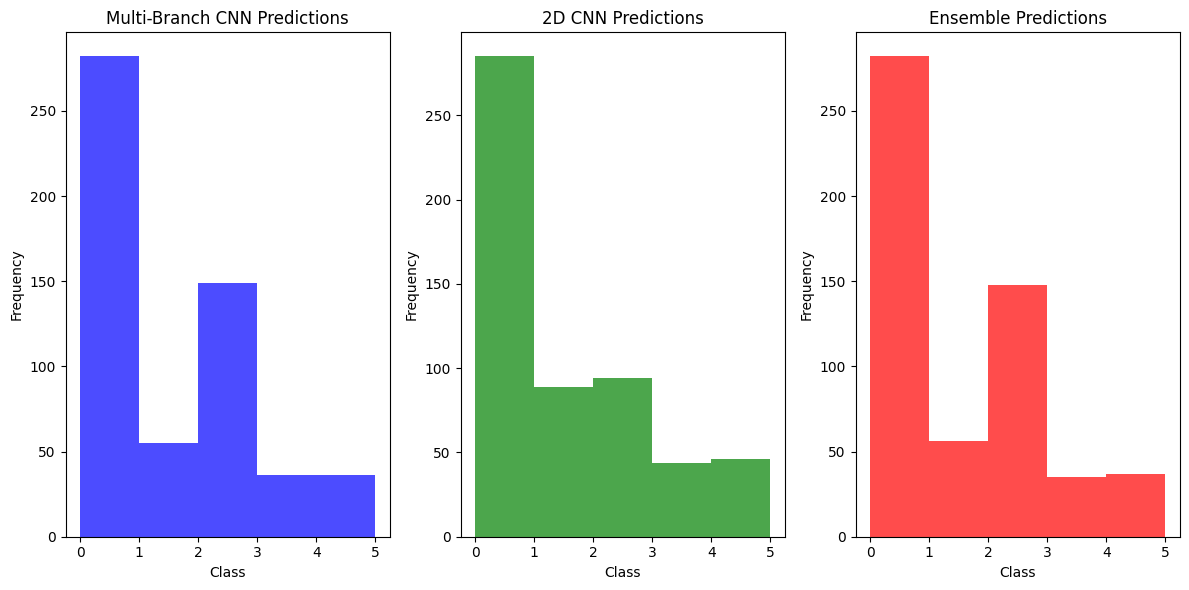

In [111]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(multibranch_class_labels, bins=5, range=(0, 5), alpha=0.7, color='blue')
plt.title('Multi-Branch CNN Predictions')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(cnn_class_labels, bins=5, range=(0, 5), alpha=0.7, color='green')
plt.title('2D CNN Predictions')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Ensemble predictions
plt.subplot(1, 3, 3)
plt.hist(ensemble_class_labels, bins=5, range=(0, 5), alpha=0.7, color='red')
plt.title('Ensemble Predictions')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## PREDICTING WITH USER INPUTS

In [113]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [115]:
def preprocess_image(image_path, img_size=224):
    """
    Preprocesses the image using CLAHE and resizes it.
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Unable to read image at path: {image_path}")

    image = cv2.resize(image, (img_size, img_size))
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    merged_lab = cv2.merge((l_clahe, a, b))
    final_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)

    final_image = final_image / 255.0  # Normalize to [0, 1]
    return final_image

In [116]:
def saliency_map(model, img_array):
    """
    Generates a Saliency Map for a given model and image.
    """
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_pred = tf.argmax(predictions[0])
        loss = predictions[:, top_pred]

    grads = tape.gradient(loss, img_tensor)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()
    return saliency

In [117]:
def predict_with_explanations(image_path, multibranch_model, cnn_model, img_size=224, weight_multibranch=0.7, weight_cnn=0.3):
    """
    Predicts the class probabilities for an image using multi-branch CNN, 2D CNN, and ensemble.
    Also generates Saliency Map explanations for each model.

    Args:
        image_path (str): Path to the input image.
        multibranch_model (tf.keras.Model): Trained multi-branch CNN model.
        cnn_model (tf.keras.Model): Trained 2D CNN model.
        img_size (int): Size of the input image (default: 224).
        weight_multibranch (float): Weight for multi-branch CNN in the ensemble (default: 0.7).
        weight_cnn (float): Weight for 2D CNN in the ensemble (default: 0.3).

    Returns:
        dict: A dictionary containing the predictions, confidence percentages, and Saliency Maps.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path, img_size)
    img_array = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    # Get predictions from multi-branch CNN
    multibranch_probs = multibranch_model.predict(img_array, verbose=0)[0]
    multibranch_class = np.argmax(multibranch_probs)
    multibranch_confidence = float(multibranch_probs[multibranch_class])

    # Get predictions from 2D CNN
    cnn_probs = cnn_model.predict(img_array, verbose=0)[0]
    cnn_class = np.argmax(cnn_probs)
    cnn_confidence = float(cnn_probs[cnn_class])

    # Combine predictions using weighted average for ensemble
    ensemble_probs = (weight_multibranch * multibranch_probs) + (weight_cnn * cnn_probs)
    ensemble_class = np.argmax(ensemble_probs)
    ensemble_confidence = float(ensemble_probs[ensemble_class])

    # Generate Saliency Map for multi-branch CNN
    multibranch_saliency = saliency_map(multibranch_model, img_array)

    # Generate Saliency Map for 2D CNN
    cnn_saliency = saliency_map(cnn_model, img_array)

    # Return results as a dictionary
    results = {
        "multi_branch_cnn": {
            "class": int(multibranch_class),
            "confidence": multibranch_confidence,
            "probabilities": [float(prob) for prob in multibranch_probs],
            "saliency_map": multibranch_saliency,
        },
        "2d_cnn": {
            "class": int(cnn_class),
            "confidence": cnn_confidence,
            "probabilities": [float(prob) for prob in cnn_probs],
            "saliency_map": cnn_saliency,
        },
        "ensemble": {
            "class": int(ensemble_class),
            "confidence": ensemble_confidence,
            "probabilities": [float(prob) for prob in ensemble_probs],
        },
    }
    return results

In [119]:
def visualize_results(results, original_image):
    """
    Visualizes the predictions and Saliency Map explanations.

    Args:
        results (dict): Dictionary containing predictions and Saliency Maps.
        original_image (np.array): Original input image.
    """
    plt.figure(figsize=(18, 12))

    # Display original image
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Display Saliency Map for multi-branch CNN
    plt.subplot(2, 2, 2)
    plt.imshow(results["multi_branch_cnn"]["saliency_map"], cmap="hot")
    plt.title("Saliency Map (Multi-Branch CNN)")
    plt.axis("off")

    # Display Saliency Map for 2D CNN
    plt.subplot(2, 2, 4)
    plt.imshow(results["2d_cnn"]["saliency_map"], cmap="hot")
    plt.title("Saliency Map (2D CNN)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Multi-Branch CNN Predictions:
Class: 2
Confidence: 96.72%
Probabilities: [8.853510735207237e-06, 6.047041097190231e-05, 0.9672170877456665, 0.03258519619703293, 0.00012841043644584715]

2D CNN Predictions:
Class: 2
Confidence: 84.46%
Probabilities: [0.00034627478453330696, 0.0038541906978935003, 0.8446195721626282, 0.07742638140916824, 0.07375357300043106]

Ensemble Predictions:
Class: 2
Confidence: 93.04%
Probabilities: [0.00011007989814970642, 0.001198586542159319, 0.9304378032684326, 0.04603755474090576, 0.022215960547327995]


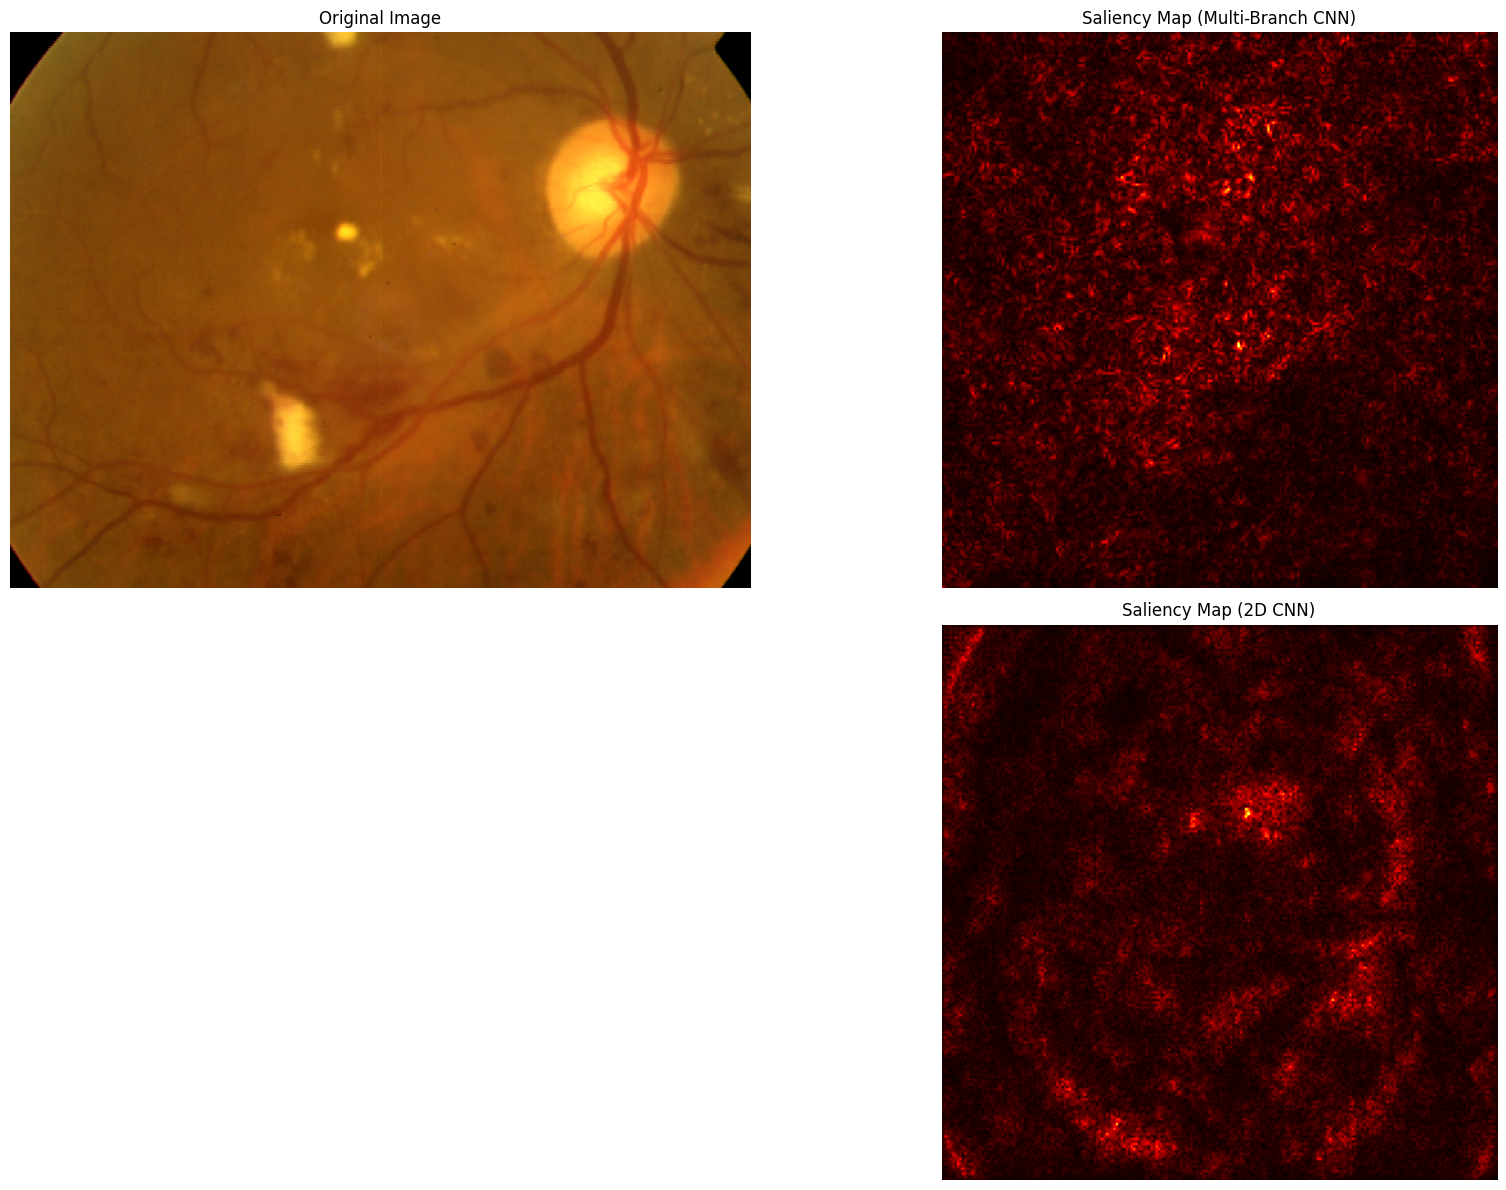

In [120]:
# Example usage
image_path = "/kaggle/input/aptos2019-blindness-detection/test_images/006efc72b638.png"
results = predict_with_explanations(image_path, multibranch_model_1, cnn_model)

# Print predictions
print("Multi-Branch CNN Predictions:")
print(f"Class: {results['multi_branch_cnn']['class']}")
print(f"Confidence: {results['multi_branch_cnn']['confidence'] * 100:.2f}%")
print(f"Probabilities: {results['multi_branch_cnn']['probabilities']}")

print("\n2D CNN Predictions:")
print(f"Class: {results['2d_cnn']['class']}")
print(f"Confidence: {results['2d_cnn']['confidence'] * 100:.2f}%")
print(f"Probabilities: {results['2d_cnn']['probabilities']}")

print("\nEnsemble Predictions:")
print(f"Class: {results['ensemble']['class']}")
print(f"Confidence: {results['ensemble']['confidence'] * 100:.2f}%")
print(f"Probabilities: {results['ensemble']['probabilities']}")

# Visualize results
original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
visualize_results(results, original_image)